In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from conllu import TokenList
import polars
import stanza
from stanza.models.common.doc import Token
from label_legends.preprocess import create_conllu, holdout, load_conllu, load_data, load_train, transform, load_vectorizer, reverse_vocabulary, vocabulary, ids_to_tokens, tokens_to_ids, vectorize_tokens, strip_stopwords
import logging

logging.basicConfig(level=logging.INFO)

/Users/jacopo/opt/miniconda3/envs/base_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import accelerate
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
import wandb
import numpy as np
import time


INFO:datasets:PyTorch version 2.2.2 available.
INFO:datasets:Polars version 1.16.0 available.


In [ ]:
val, tra = holdout()
tra = transform(tra)
val = transform(val)

# Convert 'label' column from string '0' and '1' to integer 0 and 1
tra = tra.with_columns(
    polars.col("label").cast(polars.Int32)
)
val = val.with_columns(
    polars.col("label").cast(polars.Int32)
)

/Users/jacopo/opt/miniconda3/envs/base_env/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [7]:
class SexistDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

    
    
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="micro")
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:

train_texts = tra['text'].to_list()
train_labels = tra['label'].to_list()

val_texts = val['text'].to_list()
val_labels = val['label'].to_list()

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Convert texts into token IDs using the tokenizer
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

train_dataset = SexistDataset(train_encodings, train_labels)
val_dataset = SexistDataset(val_encodings, val_labels)


In [ ]:
! wandb login
wandb.init(project='label_legends')  

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# Define the Training Arguments
training_args = TrainingArguments(
    output_dir='./results_distil',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=5e-5,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./logs',
    load_best_model_at_end=True,
    greater_is_better=False,
    logging_steps=100,
    metric_for_best_model='eval_loss',
    report_to="wandb",
)

# Define the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)



wandb: Currently logged in as: jacxpx (jacxpx-tu-wien). Use `wandb login --relogin` to force relogin


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: jacxpx (jacxpx-tu-wien). Use `wandb login --relogin` to force relogin


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/jacopo/opt/miniconda3/envs/base_env/lib/python3.12/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [10]:
# Start training and measure time
start_time = time.time()
# Train the model
trainer.train()
# Training time
training_time = time.time() - start_time

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
  1%|          | 100/11025 [02:26<3:44:56,  1.24s/it]

{'loss': 0.5589, 'grad_norm': 2.7447776794433594, 'learning_rate': 4.9546485260770975e-05, 'epoch': 0.03}


  2%|▏         | 200/11025 [04:32<3:43:41,  1.24s/it]

{'loss': 0.5131, 'grad_norm': 6.646697044372559, 'learning_rate': 4.9092970521541954e-05, 'epoch': 0.05}


  3%|▎         | 300/11025 [06:39<3:46:30,  1.27s/it]

{'loss': 0.4963, 'grad_norm': 4.314281940460205, 'learning_rate': 4.8639455782312926e-05, 'epoch': 0.08}


  4%|▎         | 400/11025 [08:44<3:40:21,  1.24s/it]

{'loss': 0.466, 'grad_norm': 1.5426466464996338, 'learning_rate': 4.8185941043083905e-05, 'epoch': 0.11}


  5%|▍         | 500/11025 [10:48<3:36:40,  1.24s/it]

{'loss': 0.4276, 'grad_norm': 3.0897648334503174, 'learning_rate': 4.773242630385488e-05, 'epoch': 0.14}


  5%|▌         | 600/11025 [13:17<6:01:31,  2.08s/it]

{'loss': 0.4786, 'grad_norm': 6.879628658294678, 'learning_rate': 4.7278911564625856e-05, 'epoch': 0.16}


  6%|▋         | 700/11025 [16:01<4:23:43,  1.53s/it]

{'loss': 0.4581, 'grad_norm': 1.7873907089233398, 'learning_rate': 4.682539682539683e-05, 'epoch': 0.19}


  7%|▋         | 800/11025 [18:44<4:27:16,  1.57s/it]

{'loss': 0.4331, 'grad_norm': 2.6954052448272705, 'learning_rate': 4.63718820861678e-05, 'epoch': 0.22}


  8%|▊         | 900/11025 [21:20<3:54:58,  1.39s/it]

{'loss': 0.4563, 'grad_norm': 3.193033456802368, 'learning_rate': 4.591836734693878e-05, 'epoch': 0.24}


  9%|▉         | 1000/11025 [23:36<3:53:12,  1.40s/it]

{'loss': 0.4183, 'grad_norm': 4.394347667694092, 'learning_rate': 4.546485260770975e-05, 'epoch': 0.27}


 10%|▉         | 1100/11025 [25:52<3:46:01,  1.37s/it]

{'loss': 0.4418, 'grad_norm': 2.055093765258789, 'learning_rate': 4.501133786848073e-05, 'epoch': 0.3}


 11%|█         | 1200/11025 [28:12<3:47:47,  1.39s/it]

{'loss': 0.4104, 'grad_norm': 0.7655039429664612, 'learning_rate': 4.4557823129251704e-05, 'epoch': 0.33}


 12%|█▏        | 1300/11025 [30:30<3:42:02,  1.37s/it]

{'loss': 0.4106, 'grad_norm': 5.089266777038574, 'learning_rate': 4.410430839002268e-05, 'epoch': 0.35}


 13%|█▎        | 1400/11025 [32:48<3:37:40,  1.36s/it]

{'loss': 0.4165, 'grad_norm': 7.979682922363281, 'learning_rate': 4.3650793650793655e-05, 'epoch': 0.38}


 14%|█▎        | 1500/11025 [35:06<3:39:34,  1.38s/it]

{'loss': 0.4161, 'grad_norm': 36.301002502441406, 'learning_rate': 4.319727891156463e-05, 'epoch': 0.41}


 15%|█▍        | 1600/11025 [37:23<3:34:23,  1.36s/it]

{'loss': 0.4197, 'grad_norm': 3.14168119430542, 'learning_rate': 4.2743764172335606e-05, 'epoch': 0.44}


 15%|█▌        | 1700/11025 [39:41<3:40:49,  1.42s/it]

{'loss': 0.4525, 'grad_norm': 4.36561918258667, 'learning_rate': 4.229024943310658e-05, 'epoch': 0.46}


 16%|█▋        | 1800/11025 [41:57<3:30:10,  1.37s/it]

{'loss': 0.4172, 'grad_norm': 4.389247894287109, 'learning_rate': 4.183673469387756e-05, 'epoch': 0.49}


 17%|█▋        | 1900/11025 [44:15<3:26:30,  1.36s/it]

{'loss': 0.393, 'grad_norm': 2.1953959465026855, 'learning_rate': 4.138321995464853e-05, 'epoch': 0.52}


 18%|█▊        | 2000/11025 [46:32<3:16:17,  1.31s/it]

{'loss': 0.4042, 'grad_norm': 5.006818771362305, 'learning_rate': 4.09297052154195e-05, 'epoch': 0.54}


 19%|█▉        | 2100/11025 [48:46<3:17:25,  1.33s/it]

{'loss': 0.3879, 'grad_norm': 4.266907691955566, 'learning_rate': 4.047619047619048e-05, 'epoch': 0.57}


 20%|█▉        | 2200/11025 [51:01<3:18:03,  1.35s/it]

{'loss': 0.3921, 'grad_norm': 8.469348907470703, 'learning_rate': 4.002267573696145e-05, 'epoch': 0.6}


 21%|██        | 2300/11025 [53:15<3:17:27,  1.36s/it]

{'loss': 0.4481, 'grad_norm': 9.728279113769531, 'learning_rate': 3.956916099773243e-05, 'epoch': 0.63}


 22%|██▏       | 2400/11025 [55:29<3:10:29,  1.33s/it]

{'loss': 0.4265, 'grad_norm': 6.628108978271484, 'learning_rate': 3.9115646258503405e-05, 'epoch': 0.65}


 23%|██▎       | 2500/11025 [57:43<3:09:17,  1.33s/it]

{'loss': 0.396, 'grad_norm': 3.1480557918548584, 'learning_rate': 3.8662131519274384e-05, 'epoch': 0.68}


 24%|██▎       | 2600/11025 [59:59<3:11:18,  1.36s/it]

{'loss': 0.4237, 'grad_norm': 8.521184921264648, 'learning_rate': 3.8208616780045356e-05, 'epoch': 0.71}


 24%|██▍       | 2700/11025 [1:02:12<3:03:48,  1.32s/it]

{'loss': 0.4041, 'grad_norm': 2.003352165222168, 'learning_rate': 3.775510204081633e-05, 'epoch': 0.73}


 25%|██▌       | 2800/11025 [1:04:23<2:57:36,  1.30s/it]

{'loss': 0.3943, 'grad_norm': 22.04106903076172, 'learning_rate': 3.730158730158731e-05, 'epoch': 0.76}


 26%|██▋       | 2900/11025 [1:06:33<2:56:46,  1.31s/it]

{'loss': 0.3946, 'grad_norm': 0.5426385998725891, 'learning_rate': 3.684807256235828e-05, 'epoch': 0.79}


 27%|██▋       | 3000/11025 [1:08:45<2:55:31,  1.31s/it]

{'loss': 0.3884, 'grad_norm': 4.5289201736450195, 'learning_rate': 3.639455782312925e-05, 'epoch': 0.82}


 28%|██▊       | 3100/11025 [1:11:02<2:51:04,  1.30s/it]

{'loss': 0.3872, 'grad_norm': 0.7712206244468689, 'learning_rate': 3.594104308390023e-05, 'epoch': 0.84}


 29%|██▉       | 3200/11025 [1:13:14<2:51:51,  1.32s/it]

{'loss': 0.3725, 'grad_norm': 2.5803914070129395, 'learning_rate': 3.54875283446712e-05, 'epoch': 0.87}


 30%|██▉       | 3300/11025 [1:15:21<2:43:13,  1.27s/it]

{'loss': 0.3994, 'grad_norm': 1.435275912284851, 'learning_rate': 3.5034013605442175e-05, 'epoch': 0.9}


 31%|███       | 3400/11025 [1:17:29<2:43:03,  1.28s/it]

{'loss': 0.4345, 'grad_norm': 4.516357421875, 'learning_rate': 3.4580498866213154e-05, 'epoch': 0.93}


 32%|███▏      | 3500/11025 [1:19:39<2:39:08,  1.27s/it]

{'loss': 0.3911, 'grad_norm': 0.9398093223571777, 'learning_rate': 3.412698412698413e-05, 'epoch': 0.95}


 33%|███▎      | 3600/11025 [1:21:46<2:50:58,  1.38s/it]

{'loss': 0.4061, 'grad_norm': 3.592756509780884, 'learning_rate': 3.36734693877551e-05, 'epoch': 0.98}


                                                        
 33%|███▎      | 3675/11025 [1:31:03<2:34:50,  1.26s/it]

{'eval_loss': 0.3659842610359192, 'eval_accuracy': 0.8531746031746031, 'eval_f1': 0.8531746031746031, 'eval_precision': 0.8531746031746031, 'eval_recall': 0.8531746031746031, 'eval_runtime': 460.5832, 'eval_samples_per_second': 27.357, 'eval_steps_per_second': 3.42, 'epoch': 1.0}


 34%|███▎      | 3700/11025 [1:31:38<2:37:27,  1.29s/it]   

{'loss': 0.4, 'grad_norm': 0.7544082999229431, 'learning_rate': 3.321995464852608e-05, 'epoch': 1.01}


 34%|███▍      | 3800/11025 [1:33:45<2:32:27,  1.27s/it]

{'loss': 0.3441, 'grad_norm': 10.075876235961914, 'learning_rate': 3.276643990929705e-05, 'epoch': 1.03}


 35%|███▌      | 3900/11025 [1:35:52<2:29:20,  1.26s/it]

{'loss': 0.3174, 'grad_norm': 4.781686782836914, 'learning_rate': 3.231292517006803e-05, 'epoch': 1.06}


 36%|███▋      | 4000/11025 [1:38:00<2:28:57,  1.27s/it]

{'loss': 0.3567, 'grad_norm': 8.090239524841309, 'learning_rate': 3.1859410430839e-05, 'epoch': 1.09}


 37%|███▋      | 4100/11025 [1:40:06<2:25:33,  1.26s/it]

{'loss': 0.3808, 'grad_norm': 5.296970844268799, 'learning_rate': 3.1405895691609974e-05, 'epoch': 1.12}


 38%|███▊      | 4200/11025 [1:42:14<2:24:47,  1.27s/it]

{'loss': 0.2932, 'grad_norm': 9.507024765014648, 'learning_rate': 3.095238095238095e-05, 'epoch': 1.14}


 39%|███▉      | 4300/11025 [1:44:21<2:27:49,  1.32s/it]

{'loss': 0.3182, 'grad_norm': 9.162334442138672, 'learning_rate': 3.049886621315193e-05, 'epoch': 1.17}


 40%|███▉      | 4400/11025 [1:46:27<2:17:58,  1.25s/it]

{'loss': 0.3642, 'grad_norm': 11.561713218688965, 'learning_rate': 3.0045351473922904e-05, 'epoch': 1.2}


 41%|████      | 4500/11025 [1:48:33<2:15:00,  1.24s/it]

{'loss': 0.3127, 'grad_norm': 1.924241542816162, 'learning_rate': 2.959183673469388e-05, 'epoch': 1.22}


 42%|████▏     | 4600/11025 [1:50:38<2:13:19,  1.25s/it]

{'loss': 0.3358, 'grad_norm': 7.101192474365234, 'learning_rate': 2.9138321995464856e-05, 'epoch': 1.25}


 43%|████▎     | 4700/11025 [1:52:43<2:10:14,  1.24s/it]

{'loss': 0.3472, 'grad_norm': 24.662109375, 'learning_rate': 2.8684807256235828e-05, 'epoch': 1.28}


 44%|████▎     | 4800/11025 [1:54:48<2:09:11,  1.25s/it]

{'loss': 0.35, 'grad_norm': 6.6253767013549805, 'learning_rate': 2.8231292517006803e-05, 'epoch': 1.31}


 44%|████▍     | 4900/11025 [1:57:03<2:17:23,  1.35s/it]

{'loss': 0.2987, 'grad_norm': 9.493478775024414, 'learning_rate': 2.777777777777778e-05, 'epoch': 1.33}


 45%|████▌     | 5000/11025 [1:59:07<1:59:38,  1.19s/it]

{'loss': 0.344, 'grad_norm': 2.2337772846221924, 'learning_rate': 2.732426303854875e-05, 'epoch': 1.36}


 46%|████▋     | 5100/11025 [2:01:12<2:06:10,  1.28s/it]

{'loss': 0.3443, 'grad_norm': 3.639249324798584, 'learning_rate': 2.687074829931973e-05, 'epoch': 1.39}


 47%|████▋     | 5200/11025 [2:03:18<2:01:40,  1.25s/it]

{'loss': 0.3212, 'grad_norm': 0.7332595586776733, 'learning_rate': 2.6417233560090703e-05, 'epoch': 1.41}


 48%|████▊     | 5300/11025 [2:05:23<1:58:03,  1.24s/it]

{'loss': 0.3862, 'grad_norm': 0.805935263633728, 'learning_rate': 2.5963718820861675e-05, 'epoch': 1.44}


 49%|████▉     | 5400/11025 [2:07:28<1:56:00,  1.24s/it]

{'loss': 0.2913, 'grad_norm': 13.646661758422852, 'learning_rate': 2.5510204081632654e-05, 'epoch': 1.47}


 50%|████▉     | 5500/11025 [2:09:33<1:53:47,  1.24s/it]

{'loss': 0.3294, 'grad_norm': 9.725075721740723, 'learning_rate': 2.5056689342403626e-05, 'epoch': 1.5}


 51%|█████     | 5600/11025 [2:11:39<1:51:53,  1.24s/it]

{'loss': 0.3039, 'grad_norm': 3.3434770107269287, 'learning_rate': 2.4603174603174602e-05, 'epoch': 1.52}


 52%|█████▏    | 5700/11025 [2:13:47<1:53:56,  1.28s/it]

{'loss': 0.3627, 'grad_norm': 2.6367993354797363, 'learning_rate': 2.4149659863945578e-05, 'epoch': 1.55}


 53%|█████▎    | 5800/11025 [2:15:54<1:48:08,  1.24s/it]

{'loss': 0.309, 'grad_norm': 8.702120780944824, 'learning_rate': 2.3696145124716553e-05, 'epoch': 1.58}


 54%|█████▎    | 5900/11025 [2:18:00<1:46:33,  1.25s/it]

{'loss': 0.3131, 'grad_norm': 0.7382391691207886, 'learning_rate': 2.324263038548753e-05, 'epoch': 1.61}


 54%|█████▍    | 6000/11025 [2:20:06<1:45:05,  1.25s/it]

{'loss': 0.3433, 'grad_norm': 5.740652561187744, 'learning_rate': 2.2789115646258505e-05, 'epoch': 1.63}


 55%|█████▌    | 6100/11025 [2:22:11<1:41:53,  1.24s/it]

{'loss': 0.2907, 'grad_norm': 1.6802324056625366, 'learning_rate': 2.233560090702948e-05, 'epoch': 1.66}


 56%|█████▌    | 6200/11025 [2:24:16<1:39:56,  1.24s/it]

{'loss': 0.3574, 'grad_norm': 6.19974946975708, 'learning_rate': 2.1882086167800456e-05, 'epoch': 1.69}


 57%|█████▋    | 6300/11025 [2:26:22<1:38:35,  1.25s/it]

{'loss': 0.3455, 'grad_norm': 3.060197591781616, 'learning_rate': 2.1428571428571428e-05, 'epoch': 1.71}


 58%|█████▊    | 6400/11025 [2:28:29<1:36:27,  1.25s/it]

{'loss': 0.3319, 'grad_norm': 4.274257183074951, 'learning_rate': 2.0975056689342404e-05, 'epoch': 1.74}


 59%|█████▉    | 6500/11025 [2:30:36<1:34:43,  1.26s/it]

{'loss': 0.3285, 'grad_norm': 0.3540050685405731, 'learning_rate': 2.052154195011338e-05, 'epoch': 1.77}


 60%|█████▉    | 6600/11025 [2:32:42<1:31:05,  1.24s/it]

{'loss': 0.3289, 'grad_norm': 6.08294153213501, 'learning_rate': 2.0068027210884355e-05, 'epoch': 1.8}


 61%|██████    | 6700/11025 [2:34:48<1:29:16,  1.24s/it]

{'loss': 0.3603, 'grad_norm': 12.170863151550293, 'learning_rate': 1.961451247165533e-05, 'epoch': 1.82}


 62%|██████▏   | 6800/11025 [2:36:53<1:27:26,  1.24s/it]

{'loss': 0.3333, 'grad_norm': 6.393932342529297, 'learning_rate': 1.9160997732426306e-05, 'epoch': 1.85}


 63%|██████▎   | 6900/11025 [2:38:59<1:25:17,  1.24s/it]

{'loss': 0.3322, 'grad_norm': 0.7069829106330872, 'learning_rate': 1.8707482993197282e-05, 'epoch': 1.88}


 63%|██████▎   | 7000/11025 [2:41:09<1:24:53,  1.27s/it]

{'loss': 0.3332, 'grad_norm': 6.503458023071289, 'learning_rate': 1.8253968253968254e-05, 'epoch': 1.9}


 64%|██████▍   | 7100/11025 [2:43:14<1:17:56,  1.19s/it]

{'loss': 0.3468, 'grad_norm': 2.875546932220459, 'learning_rate': 1.780045351473923e-05, 'epoch': 1.93}


 65%|██████▌   | 7200/11025 [2:45:15<1:15:41,  1.19s/it]

{'loss': 0.3564, 'grad_norm': 1.5366216897964478, 'learning_rate': 1.7346938775510206e-05, 'epoch': 1.96}


 66%|██████▌   | 7300/11025 [2:47:16<1:13:55,  1.19s/it]

{'loss': 0.3424, 'grad_norm': 1.8326820135116577, 'learning_rate': 1.689342403628118e-05, 'epoch': 1.99}


                                                        
 67%|██████▋   | 7350/11025 [2:55:18<1:14:06,  1.21s/it]

{'eval_loss': 0.41998782753944397, 'eval_accuracy': 0.8617460317460317, 'eval_f1': 0.8617460317460317, 'eval_precision': 0.8617460317460317, 'eval_recall': 0.8617460317460317, 'eval_runtime': 421.445, 'eval_samples_per_second': 29.897, 'eval_steps_per_second': 3.737, 'epoch': 2.0}


 67%|██████▋   | 7400/11025 [2:56:22<1:13:09,  1.21s/it]   

{'loss': 0.3085, 'grad_norm': 0.5238890647888184, 'learning_rate': 1.6439909297052157e-05, 'epoch': 2.01}


 68%|██████▊   | 7500/11025 [2:58:25<1:10:42,  1.20s/it]

{'loss': 0.2645, 'grad_norm': 1.5337721109390259, 'learning_rate': 1.5986394557823133e-05, 'epoch': 2.04}


 69%|██████▉   | 7600/11025 [3:00:26<1:08:53,  1.21s/it]

{'loss': 0.2125, 'grad_norm': 0.7260395884513855, 'learning_rate': 1.5532879818594105e-05, 'epoch': 2.07}


 70%|██████▉   | 7700/11025 [3:02:28<1:07:05,  1.21s/it]

{'loss': 0.2873, 'grad_norm': 0.25914856791496277, 'learning_rate': 1.5079365079365079e-05, 'epoch': 2.1}


 71%|███████   | 7800/11025 [3:04:30<1:04:27,  1.20s/it]

{'loss': 0.2595, 'grad_norm': 11.221879005432129, 'learning_rate': 1.4625850340136055e-05, 'epoch': 2.12}


 72%|███████▏  | 7900/11025 [3:06:32<1:02:43,  1.20s/it]

{'loss': 0.2323, 'grad_norm': 7.958322525024414, 'learning_rate': 1.417233560090703e-05, 'epoch': 2.15}


 73%|███████▎  | 8000/11025 [3:08:33<1:01:24,  1.22s/it]

{'loss': 0.2928, 'grad_norm': 18.519573211669922, 'learning_rate': 1.3718820861678006e-05, 'epoch': 2.18}


 73%|███████▎  | 8100/11025 [3:10:35<59:56,  1.23s/it]  

{'loss': 0.2867, 'grad_norm': 8.918336868286133, 'learning_rate': 1.3265306122448982e-05, 'epoch': 2.2}


 74%|███████▍  | 8200/11025 [3:12:35<55:47,  1.19s/it]  

{'loss': 0.216, 'grad_norm': 2.746347665786743, 'learning_rate': 1.2811791383219957e-05, 'epoch': 2.23}


 75%|███████▌  | 8300/11025 [3:14:36<54:59,  1.21s/it]  

{'loss': 0.2953, 'grad_norm': 10.883813858032227, 'learning_rate': 1.2358276643990931e-05, 'epoch': 2.26}


 76%|███████▌  | 8400/11025 [3:16:36<53:05,  1.21s/it]

{'loss': 0.2711, 'grad_norm': 1.4613553285598755, 'learning_rate': 1.1904761904761905e-05, 'epoch': 2.29}


 77%|███████▋  | 8500/11025 [3:18:36<49:58,  1.19s/it]

{'loss': 0.2488, 'grad_norm': 14.550854682922363, 'learning_rate': 1.145124716553288e-05, 'epoch': 2.31}


 78%|███████▊  | 8600/11025 [3:20:39<50:06,  1.24s/it]

{'loss': 0.2849, 'grad_norm': 0.23843778669834137, 'learning_rate': 1.0997732426303856e-05, 'epoch': 2.34}


 79%|███████▉  | 8700/11025 [3:22:43<45:42,  1.18s/it]

{'loss': 0.2925, 'grad_norm': 6.991462707519531, 'learning_rate': 1.054421768707483e-05, 'epoch': 2.37}


 80%|███████▉  | 8800/11025 [3:24:48<46:42,  1.26s/it]

{'loss': 0.2845, 'grad_norm': 10.595337867736816, 'learning_rate': 1.0090702947845804e-05, 'epoch': 2.39}


 81%|████████  | 8900/11025 [3:26:53<43:45,  1.24s/it]

{'loss': 0.2533, 'grad_norm': 9.543102264404297, 'learning_rate': 9.63718820861678e-06, 'epoch': 2.42}


 82%|████████▏ | 9000/11025 [3:28:58<41:45,  1.24s/it]

{'loss': 0.3124, 'grad_norm': 8.685309410095215, 'learning_rate': 9.183673469387756e-06, 'epoch': 2.45}


 83%|████████▎ | 9100/11025 [3:31:03<39:55,  1.24s/it]

{'loss': 0.2604, 'grad_norm': 0.7140035629272461, 'learning_rate': 8.73015873015873e-06, 'epoch': 2.48}


 83%|████████▎ | 9200/11025 [3:33:09<37:55,  1.25s/it]

{'loss': 0.3373, 'grad_norm': 1.3491498231887817, 'learning_rate': 8.276643990929705e-06, 'epoch': 2.5}


 84%|████████▍ | 9300/11025 [3:35:13<34:35,  1.20s/it]

{'loss': 0.2611, 'grad_norm': 0.5938283801078796, 'learning_rate': 7.823129251700681e-06, 'epoch': 2.53}


 85%|████████▌ | 9400/11025 [3:37:13<32:56,  1.22s/it]

{'loss': 0.2586, 'grad_norm': 3.6945743560791016, 'learning_rate': 7.369614512471655e-06, 'epoch': 2.56}


 86%|████████▌ | 9500/11025 [3:39:20<31:53,  1.25s/it]

{'loss': 0.2767, 'grad_norm': 0.2844109535217285, 'learning_rate': 6.9160997732426305e-06, 'epoch': 2.59}


 87%|████████▋ | 9600/11025 [3:41:25<29:38,  1.25s/it]

{'loss': 0.2755, 'grad_norm': 4.995823383331299, 'learning_rate': 6.462585034013606e-06, 'epoch': 2.61}


 88%|████████▊ | 9700/11025 [3:43:31<27:35,  1.25s/it]

{'loss': 0.314, 'grad_norm': 1.5887020826339722, 'learning_rate': 6.009070294784581e-06, 'epoch': 2.64}


 89%|████████▉ | 9800/11025 [3:45:37<25:49,  1.27s/it]

{'loss': 0.2513, 'grad_norm': 0.9970874786376953, 'learning_rate': 5.555555555555556e-06, 'epoch': 2.67}


 90%|████████▉ | 9900/11025 [3:47:42<23:24,  1.25s/it]

{'loss': 0.2664, 'grad_norm': 0.32011178135871887, 'learning_rate': 5.102040816326531e-06, 'epoch': 2.69}


 91%|█████████ | 10000/11025 [3:49:47<21:15,  1.24s/it]

{'loss': 0.265, 'grad_norm': 4.783430576324463, 'learning_rate': 4.6485260770975054e-06, 'epoch': 2.72}


 92%|█████████▏| 10100/11025 [3:51:53<19:11,  1.24s/it]

{'loss': 0.2836, 'grad_norm': 8.489996910095215, 'learning_rate': 4.195011337868481e-06, 'epoch': 2.75}


 93%|█████████▎| 10200/11025 [3:53:58<17:08,  1.25s/it]

{'loss': 0.2849, 'grad_norm': 6.950090408325195, 'learning_rate': 3.741496598639456e-06, 'epoch': 2.78}


 93%|█████████▎| 10300/11025 [3:56:03<14:57,  1.24s/it]

{'loss': 0.2512, 'grad_norm': 6.168155670166016, 'learning_rate': 3.2879818594104307e-06, 'epoch': 2.8}


 94%|█████████▍| 10400/11025 [3:58:08<12:56,  1.24s/it]

{'loss': 0.2648, 'grad_norm': 10.944540977478027, 'learning_rate': 2.8344671201814064e-06, 'epoch': 2.83}


 95%|█████████▌| 10500/11025 [4:00:14<10:26,  1.19s/it]

{'loss': 0.2767, 'grad_norm': 11.869032859802246, 'learning_rate': 2.3809523809523808e-06, 'epoch': 2.86}


 96%|█████████▌| 10600/11025 [4:02:20<08:54,  1.26s/it]

{'loss': 0.2207, 'grad_norm': 7.0189924240112305, 'learning_rate': 1.927437641723356e-06, 'epoch': 2.88}


 97%|█████████▋| 10700/11025 [4:04:27<06:48,  1.26s/it]

{'loss': 0.3182, 'grad_norm': 11.045754432678223, 'learning_rate': 1.4739229024943312e-06, 'epoch': 2.91}


 98%|█████████▊| 10800/11025 [4:06:33<04:38,  1.24s/it]

{'loss': 0.2449, 'grad_norm': 1.0004911422729492, 'learning_rate': 1.020408163265306e-06, 'epoch': 2.94}


 99%|█████████▉| 10900/11025 [4:08:40<02:36,  1.25s/it]

{'loss': 0.2789, 'grad_norm': 0.586807370185852, 'learning_rate': 5.668934240362812e-07, 'epoch': 2.97}


100%|█████████▉| 11000/11025 [4:10:46<00:31,  1.27s/it]

{'loss': 0.2833, 'grad_norm': 0.5825940370559692, 'learning_rate': 1.1337868480725624e-07, 'epoch': 2.99}


                                                       
100%|██████████| 11025/11025 [4:18:34<00:00,  1.27s/it]

{'eval_loss': 0.47488242387771606, 'eval_accuracy': 0.8626190476190476, 'eval_f1': 0.8626190476190476, 'eval_precision': 0.8626190476190476, 'eval_recall': 0.8626190476190476, 'eval_runtime': 433.0669, 'eval_samples_per_second': 29.095, 'eval_steps_per_second': 3.637, 'epoch': 3.0}


100%|██████████| 11025/11025 [4:18:36<00:00,  1.41s/it]

{'train_runtime': 15516.6709, 'train_samples_per_second': 5.684, 'train_steps_per_second': 0.711, 'train_loss': 0.3442978648317644, 'epoch': 3.0}


In [11]:
print(f"Training Time: {training_time:.2f} seconds")

# Evaluate the model
start_time = time.time()
eval_results = trainer.evaluate()
test_time = time.time() - start_time
print(f"Test Time: {test_time:.2f} seconds")

# Log final evaluation metrics to WandB
wandb.log({
    'test_time': test_time,
    'training_time': training_time,
    **eval_results  # This will include accuracy, F1, precision, recall, etc.
})

# Save the model to WandB for later use
wandb.save("./results/*")

# Finish the WandB run
wandb.finish()

Training Time: 15516.91 seconds


100%|██████████| 1575/1575 [06:51<00:00,  3.83it/s]
wandb: WARNING Symlinked 3 files into the W&B run directory, call wandb.save again to sync new files.


Test Time: 411.54 seconds


epoch,▁
eval/accuracy,▁▇█▁
eval/f1,▁▇█▁
eval/loss,▁▄█▁
eval/precision,▁▇█▁
eval/recall,▁▇█▁
eval/runtime,█▂▄▁
eval/samples_per_second,▁▆▅█
eval/steps_per_second,▁▆▅█
eval_accuracy,▁
eval_f1,▁


In [ ]:
! wandb login
wandb.init(project='label_legends')  

# Use the trainer to predict on the validation dataset
predictions = trainer.predict(val_dataset)

# Extract the predicted labels
y_pred = np.argmax(predictions.predictions, axis=1)  # Get the predicted class (highest logit)

# Extract the true labels
y_true = predictions.label_ids  # These are the true labels

wandb: Currently logged in as: jacxpx (jacxpx-tu-wien). Use `wandb login --relogin` to force relogin


In [18]:
wandb.finish()

INFO:matplotlib.font_manager:Failed to extract font properties from /System/Library/Fonts/Supplemental/NISC18030.ttf: In FT2Font: Could not set the fontsize (invalid pixel size; error code 0x17)
INFO:matplotlib.font_manager:Failed to extract font properties from /System/Library/Fonts/Apple Color Emoji.ttc: In FT2Font: Could not set the fontsize (invalid pixel size; error code 0x17)
INFO:matplotlib.font_manager:Failed to extract font properties from /System/Library/Fonts/LastResort.otf: tuple indices must be integers or slices, not str
INFO:matplotlib.font_manager:Failed to extract font properties from /System/Library/PrivateFrameworks/FontServices.framework/Resources/Reserved/PingFangUI.ttc: In FT2Font: Can not load face (locations (loca) table missing; error code 0x90)
INFO:matplotlib.font_manager:generated new fontManager


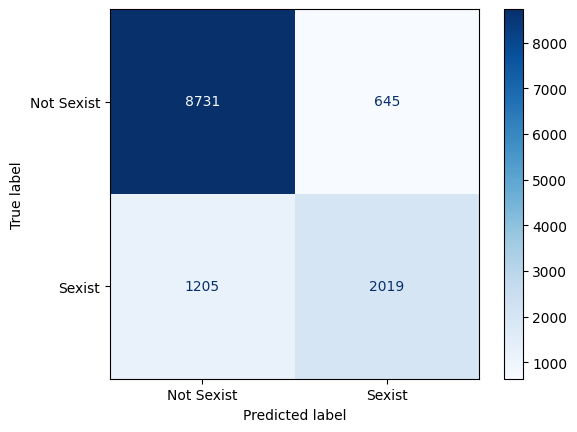

In [ ]:
# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Sexist", "Sexist"])
disp.plot(cmap="Blues")